In [132]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_excel("C:\\Users\\Anthony\\Pictures\\ml\\supervised-learning\\customer-similarity-analysis\\data\\JULY-SALES.xlsx")
print("Initial data shape:", df.shape)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Anthony\\Pictures\\ml\\supervised-learning\\customer-similarity-analysis\\data\\JULY-SALES.xlsx'

In [ ]:
# Store customer information separately
customer_info = df[['Customer', 'A/C']].copy()
print(f"Unique customers: {customer_info['Customer'].nunique()}")
print(f"Unique A/C values: {customer_info['A/C'].nunique()}")

# Check for duplicate customer entries
customer_duplicates = customer_info[customer_info.duplicated(subset=['Customer'], keep=False)]
print(f"\nDuplicate customer entries: {len(customer_duplicates)}")

# Sum the A/C values for duplicate customers row-wise
customer_duplicates = customer_duplicates.groupby('Customer', as_index=False)['A/C'].sum()


if len(customer_duplicates) > 0:
    print("Duplicate customers found:")
    print(customer_duplicates)

Unique customers: 879
Unique A/C values: 832

Duplicate customer entries: 16
Duplicate customers found:
                                    Customer    A/C
0                          KAHUNGUINI SCHOOL  12326
1          MAJID AL FUTTAIM HYPERMARKETS LTD  15648
2  MAJID AL FUTTAIM HYPERMARKETS LTD 2ND LPO   6333


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# Group by customer to aggregate purchasing behavior
customer_purchases = df.groupby('Customer').agg({
    'P': 'sum',
    'S': 'sum',
    'B': 'sum',
    '200g': 'sum',
    'O.P.': 'sum',
    '800g': 'sum',
    '600g': 'sum',
    'KATIKATI': 'sum',
    'MANDAZI': 'sum',
    'DOUGHNUTS': 'sum',
    '50-50 SLICED': 'sum',
    'MANDO FAMILY PACK': 'sum',
    '4 Square': 'sum',
    'Qty': 'sum',
    'AVG': 'mean'
}).reset_index()

# Add additional features
customer_purchases['total_products'] = customer_purchases[['P', 'S', 'B', '200g', 'O.P.', '800g', '600g',
                                                          'KATIKATI', 'MANDAZI', 'DOUGHNUTS', '50-50 SLICED',
                                                          'MANDO FAMILY PACK', '4 Square']].sum(axis=1)

# Create product preference features (percentage of each product)
product_columns = ['P', 'S', 'B', '200g', 'O.P.', '800g', '600g', 'KATIKATI', 'MANDAZI', 
                   'DOUGHNUTS', '50-50 SLICED', 'MANDO FAMILY PACK', '4 Square']

for product in product_columns:
    customer_purchases[f'{product}_ratio'] = customer_purchases[product] / (customer_purchases['total_products'] + 1e-10)

# Create product category features
customer_purchases['bread_category_total'] = customer_purchases[['P', 'S', 'B', '200g', 'O.P.', '800g', '600g']].sum(axis=1)
customer_purchases['snacks_category_total'] = customer_purchases[['KATIKATI', 'MANDAZI', 'DOUGHNUTS', '50-50 SLICED', 
                                                                 'MANDO FAMILY PACK', '4 Square']].sum(axis=1)
customer_purchases['bread_ratio'] = customer_purchases['bread_category_total'] / (customer_purchases['total_products'] + 1e-10)
customer_purchases['snacks_ratio'] = customer_purchases['snacks_category_total'] / (customer_purchases['total_products'] + 1e-10)

print("Customer purchase data shape:", customer_purchases.shape)
customer_purchases.head()

Customer purchase data shape: (879, 34)


,Customer,P,S,B,200g,O.P.,800g,600g,KATIKATI,MANDAZI,...,KATIKATI_ratio,MANDAZI_ratio,DOUGHNUTS_ratio,50-50 SLICED_ratio,MANDO FAMILY PACK_ratio,4 Square_ratio,bread_category_total,snacks_category_total,bread_ratio,snacks_ratio
0,ABIDAS GENERAL SUPPLIES LIMITED (1999),0,28527,11495,8608,0,213,5571,0,0,...,0.0,0.0,0.000367,0.000184,0.0,0.000000,54414,30.0,0.999449,0.000551
1,ACK ST LUKE'S FEEDING PROGRAMME - THIKA (5165),0,1000,190,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,1190,0.0,1.000000,0.000000
2,ADAMS KATHURIMA TITUS-1222,0,8802,5155,21932,15,0,1403,0,0,...,0.0,0.0,0.000000,-0.000027,0.0,0.000134,37307,4.0,0.999893,0.000107
3,AGNES MUENI MUGENDI (1845),0,5280,555,2400,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,8235,0.0,1.000000,0.000000
4,AGNES WANJIRU MWANGI (1511),15,6810,1688,8880,0,0,237,0,0,...,0.0,0.0,0.000000,-0.000501,0.0,0.019912,17630,349.0,0.980588,0.019412


In [ ]:
# Select features for similarity analysis
feature_columns = [
    'total_products',
    'bread_ratio', 
    'snacks_ratio',
    'Qty',
    'AVG'
] + [f'{p}_ratio' for p in product_columns]

# Select relevant features
similarity_data = customer_purchases[feature_columns].copy()

# Handle any missing values
similarity_data = similarity_data.fillna(0)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(similarity_data)

print("Data prepared for similarity analysis:", scaled_data.shape)

Data prepared for similarity analysis: (879, 18)


In [ ]:
scaled_data

array([[ 2.78023312,  0.43326873, -0.42934899, ..., -0.17428196,
        -0.10791612, -0.26381842],
       [-0.52564515,  0.4355832 , -0.431721  , ..., -0.17938814,
        -0.10791612, -0.26381842],
       [ 1.71665832,  0.4351329 , -0.4312595 , ..., -0.18013323,
        -0.10791612, -0.2628677 ],
       ...,
       [ 0.32494155,  0.41442938, -0.41004124, ..., -0.03937964,
        -0.10791612, -0.26381842],
       [ 0.24064023,  0.29592484, -0.28859037, ..., -0.17938814,
        -0.10791612, -0.02793031],
       [-0.24803431,  0.42445559, -0.42031673, ..., -0.10573902,
        -0.10791612, -0.26381842]], shape=(879, 18))

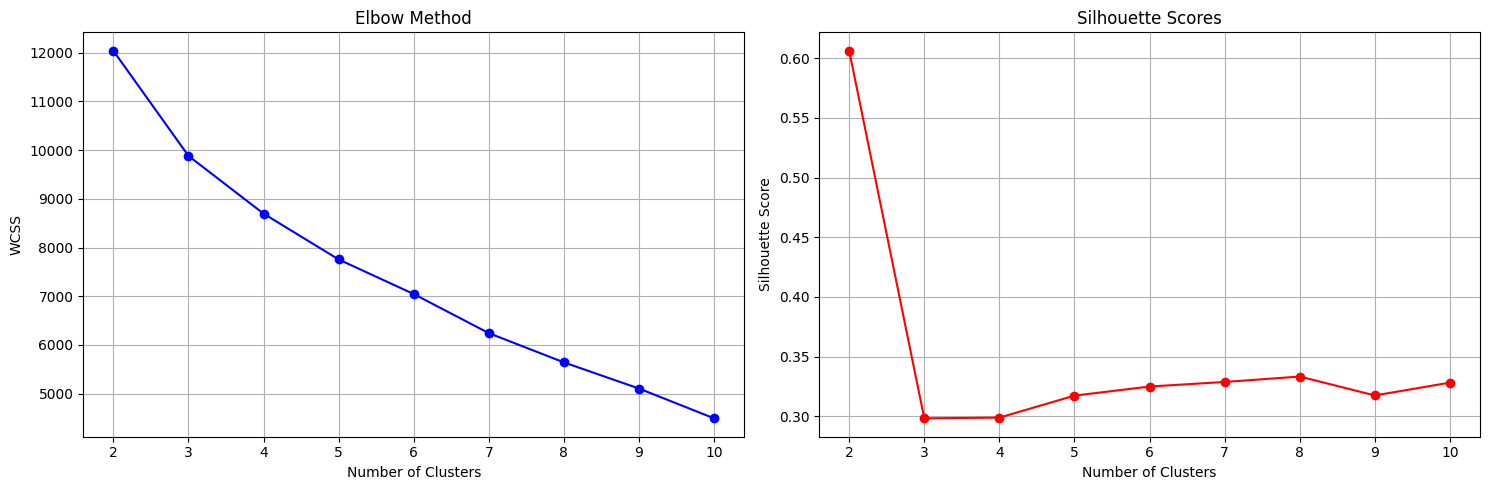

Optimal number of clusters based on silhouette score: 2

Customers per cluster:
cluster
0    823
1     56
Name: count, dtype: int64


In [ ]:
def find_optimal_clusters(data, max_clusters=10):
    """Find optimal number of clusters using elbow method and silhouette score"""
    wcss = []  # Within-cluster sum of squares
    silhouette_scores = []
    
    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        
        if len(np.unique(kmeans.labels_)) > 1:  # Silhouette requires at least 2 clusters
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))
        else:
            silhouette_scores.append(0)
    
    # Plot elbow curve
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(range(2, max_clusters + 1), wcss, 'bo-')
    axes[0].set_xlabel('Number of Clusters')
    axes[0].set_ylabel('WCSS')
    axes[0].set_title('Elbow Method')
    axes[0].grid(True)
    
    axes[1].plot(range(2, max_clusters + 1), silhouette_scores, 'ro-')
    axes[1].set_xlabel('Number of Clusters')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Scores')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal clusters (highest silhouette score)
    optimal_clusters = np.argmax(silhouette_scores) + 2
    print(f"Optimal number of clusters based on silhouette score: {optimal_clusters}")
    
    return optimal_clusters

# Find optimal number of clusters
optimal_clusters = find_optimal_clusters(scaled_data)

# Apply KMeans clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to customer data
customer_purchases['cluster'] = clusters
customer_purchases['Customer'] = customer_info['Customer'].unique()

print(f"\nCustomers per cluster:")
print(customer_purchases['cluster'].value_counts().sort_index())

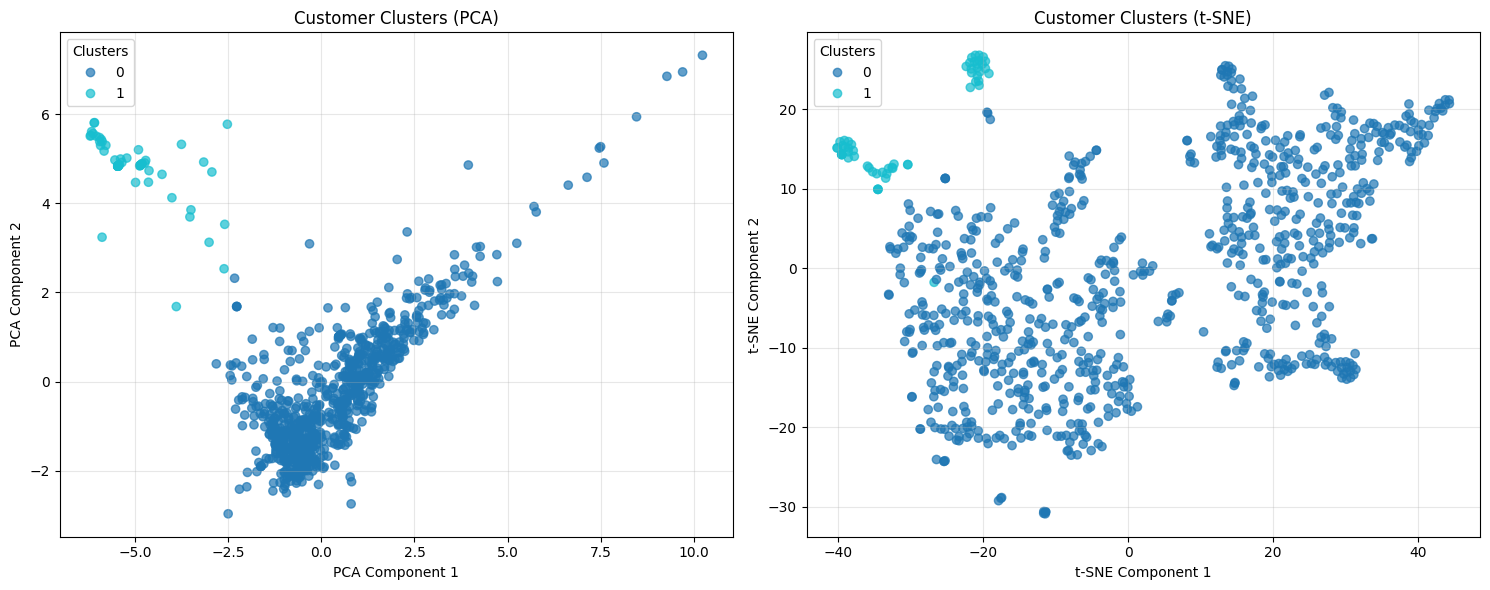

In [ ]:
def visualize_clusters(data, labels, customer_names):
    """Visualize clusters using PCA and t-SNE"""
    
    # Reduce dimensions for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(data)-1))
    tsne_result = tsne.fit_transform(data)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # PCA visualization
    scatter1 = axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[0].set_xlabel('PCA Component 1')
    axes[0].set_ylabel('PCA Component 2')
    axes[0].set_title('Customer Clusters (PCA)')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(*scatter1.legend_elements(), title="Clusters")
    
    # t-SNE visualization
    scatter2 = axes[1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[1].set_xlabel('t-SNE Component 1')
    axes[1].set_ylabel('t-SNE Component 2')
    axes[1].set_title('Customer Clusters (t-SNE)')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(*scatter2.legend_elements(), title="Clusters")
    
    plt.tight_layout()
    plt.show()
    
    return pca_result, tsne_result

# Visualize clusters
pca_result, tsne_result = visualize_clusters(scaled_data, clusters, customer_purchases['Customer'])

In [ ]:
def analyze_clusters(customer_data):
    """Analyze and display cluster characteristics"""
    
    cluster_summary = []
    
    for cluster_id in sorted(customer_data['cluster'].unique()):
        cluster_customers = customer_data[customer_data['cluster'] == cluster_id]
        
        # Calculate cluster statistics
        summary = {
            'cluster': cluster_id,
            'customer_count': len(cluster_customers),
            'avg_total_products': cluster_customers['total_products'].mean(),
            'avg_order_quantity': cluster_customers['Qty'].mean(),
            'avg_bread_ratio': cluster_customers['bread_ratio'].mean(),
            'avg_snacks_ratio': cluster_customers['snacks_ratio'].mean(),
            'top_3_products': []
        }
        
        # Find top products in this cluster
        product_ratios = cluster_customers[[f'{p}_ratio' for p in product_columns]].mean()
        top_products = product_ratios.sort_values(ascending=False).head(3)
        summary['top_3_products'] = list(top_products.index)
        
        cluster_summary.append(summary)
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(cluster_summary)
    
    return summary_df, customer_data

# Get cluster analysis
cluster_summary, clustered_customers = analyze_clusters(customer_purchases)

print("="*80)
print("CLUSTER ANALYSIS SUMMARY")
print("="*80)
print("\n" + cluster_summary.to_string(index=False))

# Display customers in each cluster
print("\n" + "="*80)
print("CUSTOMERS BY CLUSTER")
print("="*80)

for cluster_id in sorted(clustered_customers['cluster'].unique()):
    cluster_customers = clustered_customers[clustered_customers['cluster'] == cluster_id]
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id} - {len(cluster_customers)} customers")
    print(f"{'='*60}")
    
    # Get top products for this cluster
    product_ratios = cluster_customers[[f'{p}_ratio' for p in product_columns]].mean()
    top_products = product_ratios.sort_values(ascending=False).head(3)
    
    print(f"Top Products: {', '.join([p.replace('_ratio', '') for p in top_products.index])}")
    print(f"Avg Total Products: {cluster_customers['total_products'].mean():.0f}")
    print(f"Avg Order Quantity: {cluster_customers['Qty'].mean():.0f}")
    
    print("\nCustomers in this cluster:")
    for idx, row in cluster_customers.iterrows():
        print(f"  - {row['Customer']} (Total: {row['total_products']:.0f}, Qty: {row['Qty']:.0f})")

CLUSTER ANALYSIS SUMMARY

 cluster  customer_count  avg_total_products  avg_order_quantity  avg_bread_ratio  avg_snacks_ratio                                   top_3_products
       0             823        10171.857831        10171.857831         0.953708          0.042647                [S_ratio, 200g_ratio, 600g_ratio]
       1              56         2099.142857         2099.142857         0.052565          0.947435 [MANDAZI_ratio, 4 Square_ratio, DOUGHNUTS_ratio]

CUSTOMERS BY CLUSTER

CLUSTER 0 - 823 customers
Top Products: S, 200g, 600g
Avg Total Products: 10172
Avg Order Quantity: 10172

Customers in this cluster:
  - LUCY WAIRIMU KAIRU (055) (Total: 54444, Qty: 54444)
  - JAMES MWANGI (057) (Total: 1190, Qty: 1190)
  - ANTONY MWANGI (062) (Total: 37311, Qty: 37311)
  - NASHON KYULE (063) (Total: 8235, Qty: 8235)
  - PATRICK WAWERU GICHUHI (082) (Total: 17979, Qty: 17979)
  - PETER KARANJA (101) (Total: 987, Qty: 987)
  - EVANS MOSETI (153) (Total: 11823, Qty: 11823)
  - JOSEPH

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_customers(customer_name, data, customer_names, top_n=5):
    """Find most similar customers to a given customer"""
    
    if customer_name not in customer_names:
        print(f"Customer '{customer_name}' not found in data.")
        return None
    
    customer_idx = np.where(customer_names == customer_name)[0][0]
    
    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(data)
    
    # Get similarities for the target customer
    customer_similarities = similarity_matrix[customer_idx]
    
    # Get top N similar customers (excluding self)
    similar_indices = np.argsort(customer_similarities)[::-1][1:top_n+1]
    
    print(f"\n{'='*60}")
    print(f"Top {top_n} customers similar to: {customer_name}")
    print(f"{'='*60}")
    
    similar_customers = []
    for i, idx in enumerate(similar_indices, 1):
        similarity = customer_similarities[idx]
        similar_customer = customer_names[idx]
        customer_cluster = clustered_customers[clustered_customers['Customer'] == similar_customer]['cluster'].values[0]
        
        print(f"{i}. {similar_customer}")
        print(f"   Similarity Score: {similarity:.3f}")
        print(f"   Cluster: {customer_cluster}")
        
        similar_customers.append({
            'customer': similar_customer,
            'similarity': similarity,
            'cluster': customer_cluster
        })
    
    return similar_customers

# Example: Find customers similar to the first customer in the list
sample_customer = customer_purchases['Customer'].iloc[0]
similar_customers = find_similar_customers(sample_customer, scaled_data, 
                                          customer_purchases['Customer'].values, top_n=5)

# You can also find customers similar to any specific customer
print("\n" + "="*80)
print("FIND SIMILAR CUSTOMERS TO ANY SPECIFIC CUSTOMER")
print("="*80)

# modify to search for a specific customer
target_customer = "JAMES MWANGI (057)"
find_similar_customers(target_customer, scaled_data, customer_purchases['Customer'].values, top_n=5)


Top 5 customers similar to: LUCY WAIRIMU KAIRU (055)
1. CLEANSHELF SUPERMARKET - NGONG (2181)
   Similarity Score: 0.995
   Cluster: 0
2. HEYWOOD(6230) 
   Similarity Score: 0.995
   Cluster: 0
3. NAIVAS SUPERMARKET LTD- GREENHOUSE NGONG RD (1304)
   Similarity Score: 0.990
   Cluster: 0
4. SHIRIKISHO SUPERMARKETS LTD (2178)
   Similarity Score: 0.987
   Cluster: 0
5. RACHAEL WANGARI THEURI (2179)
   Similarity Score: 0.986
   Cluster: 0

FIND SIMILAR CUSTOMERS TO ANY SPECIFIC CUSTOMER

Top 5 customers similar to: JAMES MWANGI (057)
1. KHETIA DRAPERS LTD -EURO BUNGOMA (1200 )
   Similarity Score: 1.000
   Cluster: 0
2. JULIUS MUTHUI KIMENDE (573)
   Similarity Score: 0.998
   Cluster: 0
3. MANDAZI CASH SALE (6230) AKIM
   Similarity Score: 0.990
   Cluster: 0
4. MANNA LIFESTYLE SUPERMARKET - LUANDA (1955)
   Similarity Score: 0.986
   Cluster: 0
5. PETER WACHIRA WANYOIKE (1627)
   Similarity Score: 0.985
   Cluster: 0


[{'customer': 'KHETIA DRAPERS LTD -EURO BUNGOMA (1200 )',
  'similarity': np.float64(0.9995854867491419),
  'cluster': np.int32(0)},
 {'customer': 'JULIUS MUTHUI KIMENDE (573)',
  'similarity': np.float64(0.9976370659153165),
  'cluster': np.int32(0)},
 {'customer': 'MANDAZI CASH SALE (6230) AKIM',
  'similarity': np.float64(0.9900834192506358),
  'cluster': np.int32(0)},
 {'customer': 'MANNA LIFESTYLE SUPERMARKET - LUANDA (1955)',
  'similarity': np.float64(0.9860882725927624),
  'cluster': np.int32(0)},
 {'customer': 'PETER WACHIRA WANYOIKE (1627)',
  'similarity': np.float64(0.9845869626370731),
  'cluster': np.int32(0)}]

In [ ]:
def create_similarity_report(clustered_customers, output_file="customer_similarity_report.xlsx"):
    """Create comprehensive similarity report"""
    
    # Prepare report data
    report_data = clustered_customers.copy()
    
    # Add additional metrics
    report_data['product_variety'] = report_data[product_columns].gt(0).sum(axis=1)
    report_data['dominant_product'] = report_data[product_columns].idxmax(axis=1)
    report_data['dominant_product_ratio'] = report_data[[f'{p}_ratio' for p in product_columns]].max(axis=1)
    
    # Select columns for final report
    report_columns = [
        'Customer',
        'cluster',
        'total_products',
        'Qty',
        'AVG',
        'product_variety',
        'dominant_product',
        'dominant_product_ratio',
        'bread_ratio',
        'snacks_ratio'
    ] + product_columns
    
    final_report = report_data[report_columns]
    
    # Save to Excel with multiple sheets
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # Full report
        final_report.to_excel(writer, sheet_name='All Customers', index=False)
        
        # Cluster summaries
        cluster_summary.to_excel(writer, sheet_name='Cluster Summary', index=False)
        
        # Customers by cluster
        for cluster_id in sorted(final_report['cluster'].unique()):
            cluster_data = final_report[final_report['cluster'] == cluster_id]
            sheet_name = f'Cluster {cluster_id}'
            cluster_data.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f"\nReport saved to: {output_file}")
    return final_report

# Generate comprehensive report
final_report = create_similarity_report(customer_purchases)

print("\n" + "="*80)
print("REPORT PREVIEW")
print("="*80)
print(final_report.head(10))


Report saved to: customer_similarity_report.xlsx

REPORT PREVIEW
                       Customer  cluster  total_products      Qty  \
0      LUCY WAIRIMU KAIRU (055)        0         54444.0  54444.0   
1            JAMES MWANGI (057)        0          1190.0   1190.0   
2           ANTONY MWANGI (062)        0         37311.0  37311.0   
3            NASHON KYULE (063)        0          8235.0   8235.0   
4  PATRICK WAWERU GICHUHI (082)        0         17979.0  17979.0   
5          GERALD GICHUKI (100)        1           250.0    250.0   
6           PETER KARANJA (101)        0           987.0    987.0   
7      PURITY WANJA NGATIA(120)        1          7602.0   7602.0   
8            EVANS MOSETI (153)        0         11823.0  11823.0   
9     JOSEPH MWANGI MURUKU(163)        0         42858.0  42858.0   

           AVG  product_variety dominant_product  dominant_product_ratio  \
0  7777.714286                7                S                0.523970   
1   170.000000        

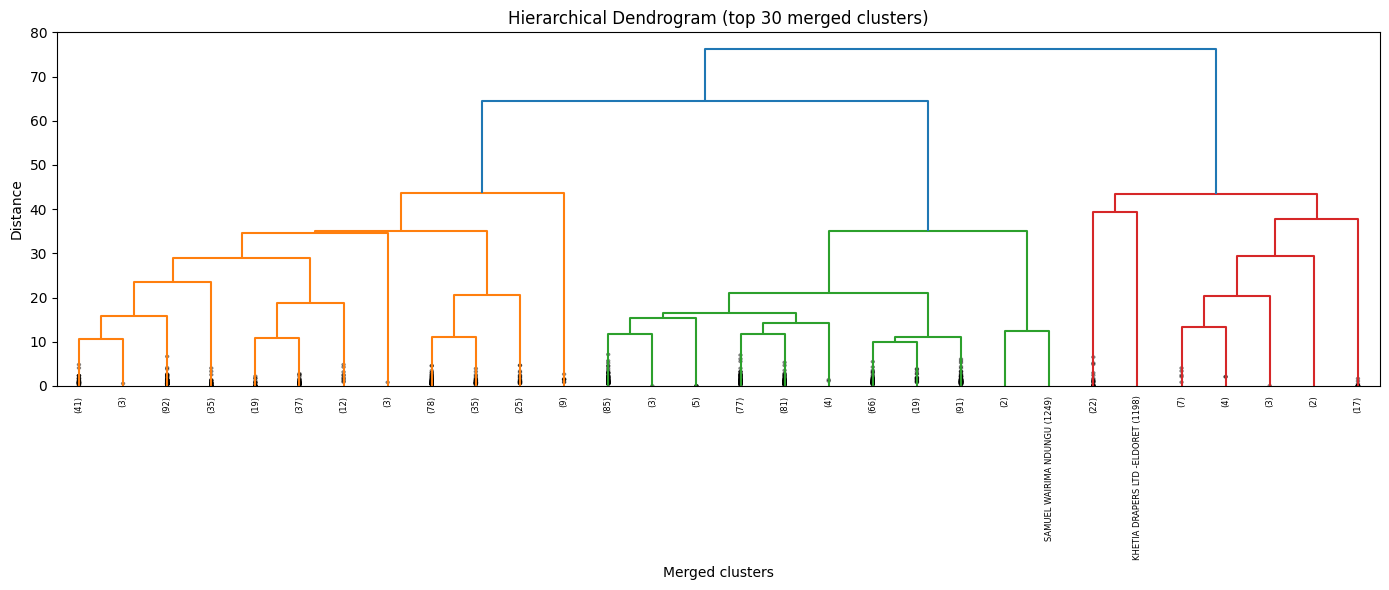


CLUSTERING COMPARISON
KMeans Silhouette Score: 0.606
Hierarchical Silhouette Score: 0.606


In [ ]:
def hierarchical_clustering_analysis(data, customer_names, truncate_last_p=30):
    """Perform hierarchical clustering analysis with a readable dendrogram"""
    # Perform hierarchical clustering (Ward forces Euclidean metric)
    linked = linkage(data, method='ward')
    
    # Truncated dendrogram for readability on large customer sets
    plt.figure(figsize=(14, 6))
    dendrogram(linked,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True,
               leaf_rotation=90,
               leaf_font_size=6,
               labels=customer_names,
               truncate_mode='lastp',
               p=truncate_last_p,
               show_contracted=True)
    plt.title(f'Hierarchical Dendrogram (top {truncate_last_p} merged clusters)')
    plt.xlabel('Merged clusters')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()
    
    # Apply Agglomerative Clustering (affinity deprecated; use metric)
    agg_clustering = AgglomerativeClustering(n_clusters=optimal_clusters, 
                                             metric='euclidean', 
                                             linkage='ward')
    hierarchical_labels = agg_clustering.fit_predict(data)
    
    # Compare with KMeans results
    print(f"\n{'='*60}")
    print("CLUSTERING COMPARISON")
    print(f"{'='*60}")
    print(f"KMeans Silhouette Score: {silhouette_score(data, clusters):.3f}")
    print(f"Hierarchical Silhouette Score: {silhouette_score(data, hierarchical_labels):.3f}")
    
    return hierarchical_labels

# Perform hierarchical clustering (adjust truncate_last_p for more/less detail)
hierarchical_labels = hierarchical_clustering_analysis(scaled_data, customer_purchases['Customer'].values, truncate_last_p=30)

CLUSTERING MODEL EVALUATION


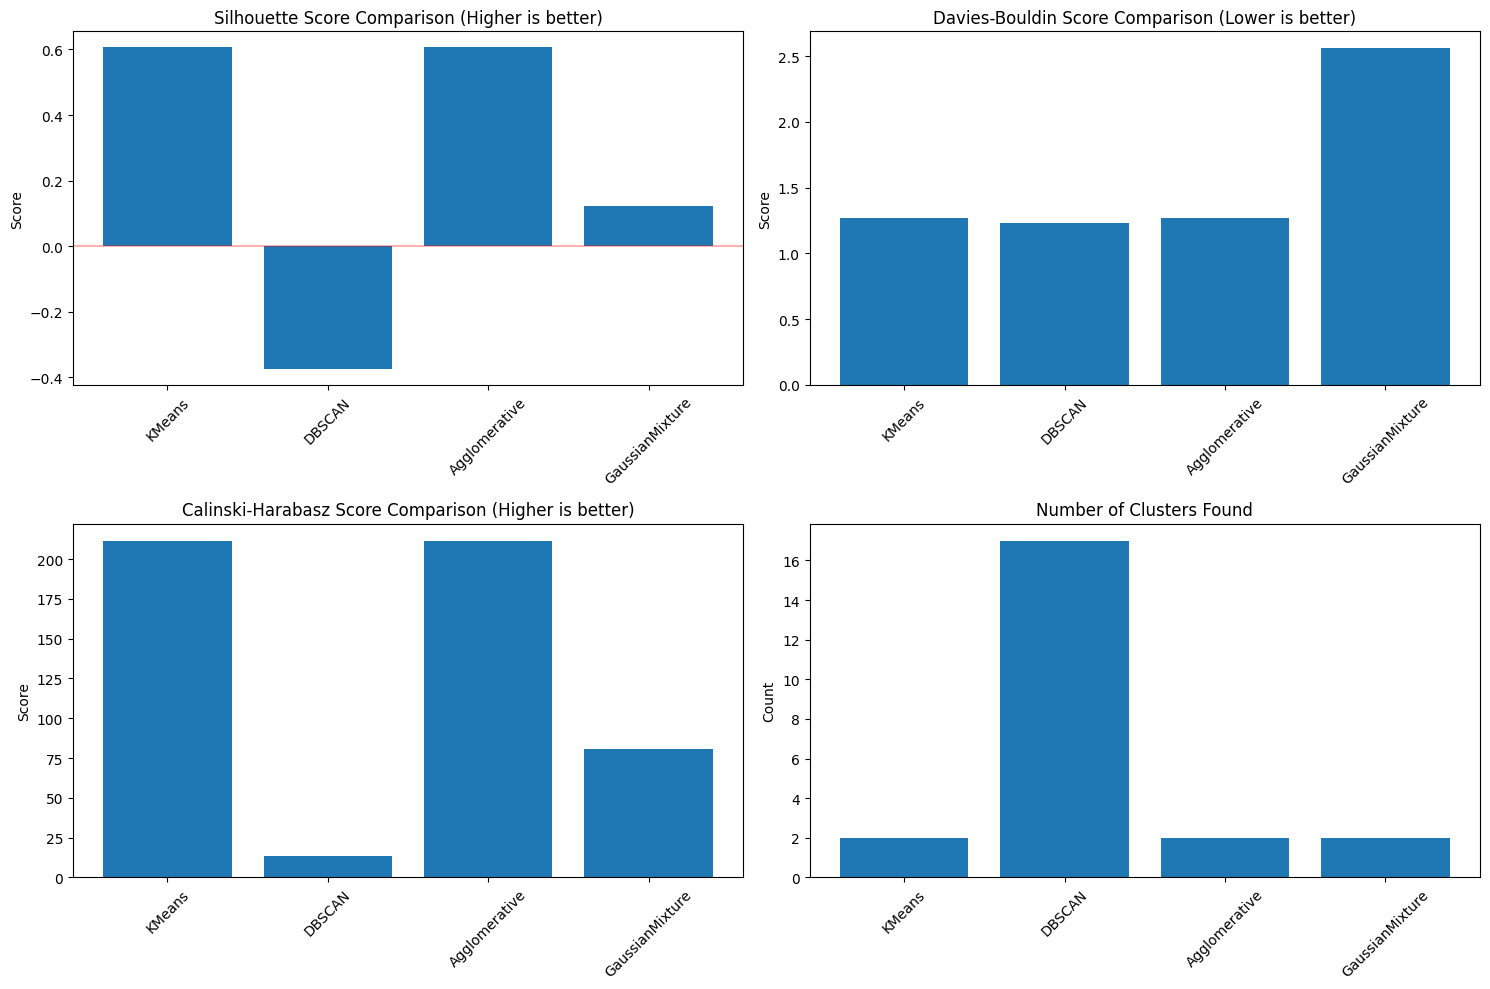


Model Evaluation Results:
          Model  Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score  Number of Clusters  Noise Points
         KMeans          0.606310              1.267800               211.629601                   2             0
         DBSCAN         -0.374284              1.233386                13.676290                  17           740
  Agglomerative          0.606310              1.267800               211.629601                   2             0
GaussianMixture          0.123187              2.561109                80.904760                   2             0


In [ ]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_clustering_models(X, y_true=None):
    """
    Evaluate different clustering models using internal validation metrics
    """
    
    models = {
        'KMeans': KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10),
        'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
        'Agglomerative': AgglomerativeClustering(n_clusters=optimal_clusters),
        'GaussianMixture': GaussianMixture(n_components=optimal_clusters, random_state=42)
    }
    
    results = []
    
    for model_name, model in models.items():
        try:
            # Fit model
            if model_name == 'GaussianMixture':
                labels = model.fit_predict(X)
            else:
                labels = model.fit_predict(X)
            
            # Calculate evaluation metrics
            if len(np.unique(labels)) > 1:
                silhouette = silhouette_score(X, labels)
                davies_bouldin = davies_bouldin_score(X, labels)
                calinski_harabasz = calinski_harabasz_score(X, labels)
            else:
                silhouette = -1
                davies_bouldin = float('inf')
                calinski_harabasz = -1
            
            # Store results
            n_clusters = len(np.unique(labels[labels != -1])) if -1 in labels else len(np.unique(labels))
            
            results.append({
                'Model': model_name,
                'Silhouette Score': silhouette,
                'Davies-Bouldin Score': davies_bouldin,
                'Calinski-Harabasz Score': calinski_harabasz,
                'Number of Clusters': n_clusters,
                'Noise Points': np.sum(labels == -1) if -1 in labels else 0
            })
            
        except Exception as e:
            print(f"Error with {model_name}: {str(e)}")
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Silhouette Score Comparison
    axes[0, 0].bar(results_df['Model'], results_df['Silhouette Score'])
    axes[0, 0].set_title('Silhouette Score Comparison (Higher is better)')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    # Davies-Bouldin Score Comparison
    axes[0, 1].bar(results_df['Model'], results_df['Davies-Bouldin Score'])
    axes[0, 1].set_title('Davies-Bouldin Score Comparison (Lower is better)')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Calinski-Harabasz Score Comparison
    axes[1, 0].bar(results_df['Model'], results_df['Calinski-Harabasz Score'])
    axes[1, 0].set_title('Calinski-Harabasz Score Comparison (Higher is better)')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Number of Clusters
    axes[1, 1].bar(results_df['Model'], results_df['Number of Clusters'])
    axes[1, 1].set_title('Number of Clusters Found')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Evaluate different clustering models
print("="*80)
print("CLUSTERING MODEL EVALUATION")
print("="*80)
evaluation_results = evaluate_clustering_models(scaled_data)
print("\nModel Evaluation Results:")
print(evaluation_results.to_string(index=False))


MODEL STABILITY VALIDATION


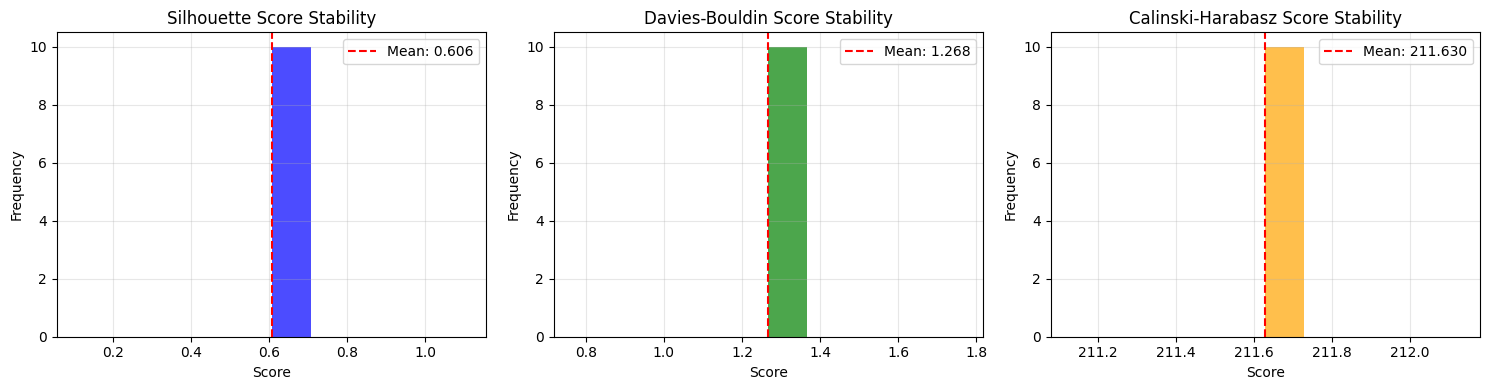


Model Stability Analysis (10 iterations):
                 Metric       Mean          Std        Min        Max
       Silhouette Score   0.606310 1.110223e-16   0.606310   0.606310
   Davies-Bouldin Score   1.267800 0.000000e+00   1.267800   1.267800
Calinski-Harabasz Score 211.629601 2.842171e-14 211.629601 211.629601


In [ ]:
def validate_model_stability(X, n_iterations=10):
    """
    Validate clustering model stability through multiple runs
    """
    
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    
    for i in range(n_iterations):
        # Initialize KMeans with different random states
        kmeans = KMeans(n_clusters=optimal_clusters, random_state=i, n_init=10)
        labels = kmeans.fit_predict(X)
        
        if len(np.unique(labels)) > 1:
            silhouette_scores.append(silhouette_score(X, labels))
            davies_bouldin_scores.append(davies_bouldin_score(X, labels))
            calinski_harabasz_scores.append(calinski_harabasz_score(X, labels))
    
    # Create stability report
    stability_df = pd.DataFrame({
        'Metric': ['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'],
        'Mean': [np.mean(silhouette_scores), np.mean(davies_bouldin_scores), np.mean(calinski_harabasz_scores)],
        'Std': [np.std(silhouette_scores), np.std(davies_bouldin_scores), np.std(calinski_harabasz_scores)],
        'Min': [np.min(silhouette_scores), np.min(davies_bouldin_scores), np.min(calinski_harabasz_scores)],
        'Max': [np.max(silhouette_scores), np.max(davies_bouldin_scores), np.max(calinski_harabasz_scores)]
    })
    
    # Plot stability results
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Silhouette Score Distribution
    axes[0].hist(silhouette_scores, bins=10, alpha=0.7, color='blue')
    axes[0].axvline(np.mean(silhouette_scores), color='red', linestyle='--', label=f'Mean: {np.mean(silhouette_scores):.3f}')
    axes[0].set_title('Silhouette Score Stability')
    axes[0].set_xlabel('Score')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Davies-Bouldin Score Distribution
    axes[1].hist(davies_bouldin_scores, bins=10, alpha=0.7, color='green')
    axes[1].axvline(np.mean(davies_bouldin_scores), color='red', linestyle='--', label=f'Mean: {np.mean(davies_bouldin_scores):.3f}')
    axes[1].set_title('Davies-Bouldin Score Stability')
    axes[1].set_xlabel('Score')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Calinski-Harabasz Score Distribution
    axes[2].hist(calinski_harabasz_scores, bins=10, alpha=0.7, color='orange')
    axes[2].axvline(np.mean(calinski_harabasz_scores), color='red', linestyle='--', label=f'Mean: {np.mean(calinski_harabasz_scores):.3f}')
    axes[2].set_title('Calinski-Harabasz Score Stability')
    axes[2].set_xlabel('Score')
    axes[2].set_ylabel('Frequency')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nModel Stability Analysis (10 iterations):")
    print(stability_df.to_string(index=False))
    
    return stability_df

# Validate model stability
print("\n" + "="*80)
print("MODEL STABILITY VALIDATION")
print("="*80)
stability_results = validate_model_stability(scaled_data)


SUPERVISED MODEL FOR CLUSTER PREDICTION

CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00        11

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176



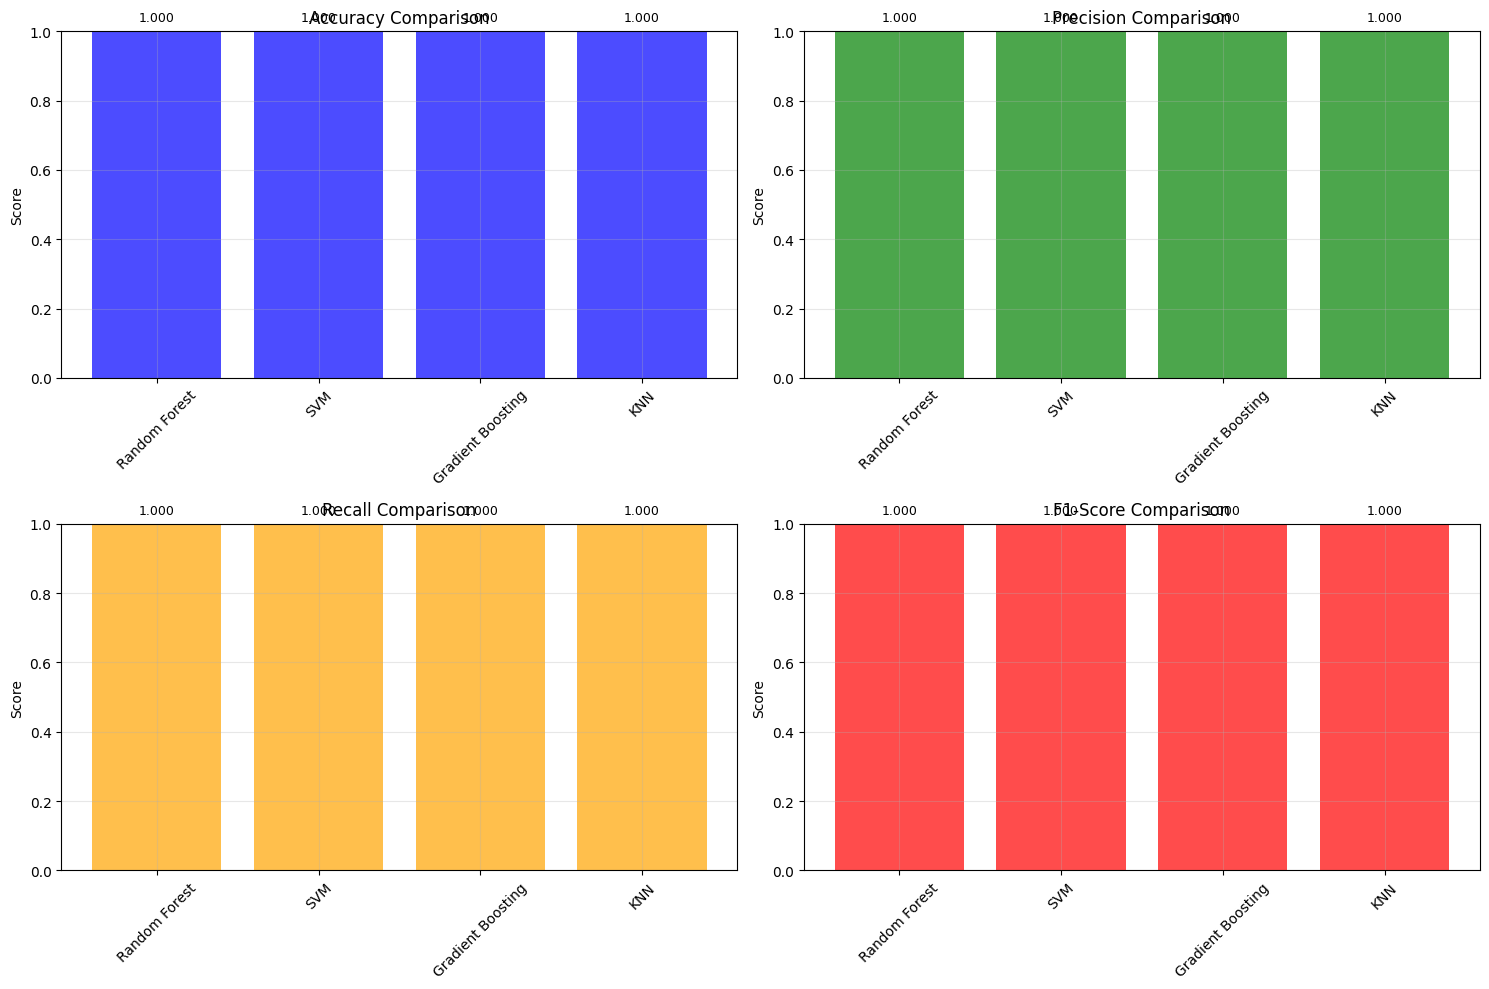


Supervised Model Results:
            Model  Accuracy  Precision  Recall  F1-Score  CV Mean Accuracy   CV Std
    Random Forest       1.0        1.0     1.0       1.0          1.000000 0.000000
              SVM       1.0        1.0     1.0       1.0          0.997721 0.002791
Gradient Boosting       1.0        1.0     1.0       1.0          1.000000 0.000000
              KNN       1.0        1.0     1.0       1.0          0.998864 0.002273


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier


def create_supervised_model(X, labels):
    """
    Create a supervised model to predict clusters for new customers
    """
    
    # Split data for supervised learning
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Define models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='rbf', random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    results = []
    
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Cross-validation
        cv_scores = cross_val_score(model, X, labels, cv=5, scoring='accuracy')
        
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'CV Mean Accuracy': cv_scores.mean(),
            'CV Std': cv_scores.std()
        })
        
        # Print classification report for best model
        if model_name == 'Random Forest':
            print(f"\n{'='*60}")
            print(f"CLASSIFICATION REPORT - {model_name}")
            print(f"{'='*60}")
            print(classification_report(y_test, y_pred))
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Plot model comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['blue', 'green', 'orange', 'red']
    
    for idx, (ax, metric, color) in enumerate(zip(axes.flat, metrics_to_plot, colors)):
        ax.bar(results_df['Model'], results_df[metric], color=color, alpha=0.7)
        ax.set_title(f'{metric} Comparison')
        ax.set_ylabel('Score')
        ax.set_ylim([0, 1])
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, v in enumerate(results_df[metric]):
            ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return results_df, models['Random Forest']  # Return best model

# Create supervised model for prediction
print("\n" + "="*80)
print("SUPERVISED MODEL FOR CLUSTER PREDICTION")
print("="*80)

supervised_results, best_model = create_supervised_model(scaled_data, clusters)

print("\nSupervised Model Results:")
print(supervised_results.to_string(index=False))

In [ ]:
class CustomerSimilarityPredictor:
    """
    Complete pipeline for predicting customer similarity and clusters
    """
    
    def __init__(self, scaler, clustering_model, supervised_model, feature_columns, product_columns):
        self.scaler = scaler
        self.clustering_model = clustering_model
        self.supervised_model = supervised_model
        self.feature_columns = feature_columns
        self.product_columns = product_columns
        self.customer_data = None  # Store training customer data for similarity
        
    def preprocess_new_customer(self, customer_data):
        """
        Preprocess new customer data in the same way as training data
        """
        # Ensure we have all required columns
        for col in self.product_columns:
            if col not in customer_data.columns:
                customer_data[col] = 0
        
        # Calculate total products
        customer_data['total_products'] = customer_data[self.product_columns].sum(axis=1)
        
        # Calculate product ratios
        for product in self.product_columns:
            customer_data[f'{product}_ratio'] = customer_data[product] / (customer_data['total_products'] + 1e-10)
        
        # Calculate category ratios
        customer_data['bread_category_total'] = customer_data[['P', 'S', 'B', '200g', 'O.P.', '800g', '600g']].sum(axis=1)
        customer_data['snacks_category_total'] = customer_data[['KATIKATI', 'MANDAZI', 'DOUGHNUTS', '50-50 SLICED', 
                                                               'MANDO FAMILY PACK', '4 Square']].sum(axis=1)
        customer_data['bread_ratio'] = customer_data['bread_category_total'] / (customer_data['total_products'] + 1e-10)
        customer_data['snacks_ratio'] = customer_data['snacks_category_total'] / (customer_data['total_products'] + 1e-10)
        
        # Select features for prediction
        features = customer_data[self.feature_columns].copy()
        
        # Fill any missing values
        features = features.fillna(0)
        
        return features
    
    def predict_cluster(self, new_customer_features):
        """
        Predict cluster for new customer
        """
        # Scale features
        scaled_features = self.scaler.transform(new_customer_features)
        
        # Predict using supervised model
        cluster_prediction = self.supervised_model.predict(scaled_features)
        
        # Get prediction probabilities
        if hasattr(self.supervised_model, 'predict_proba'):
            probabilities = self.supervised_model.predict_proba(scaled_features)
        else:
            probabilities = None
        
        return cluster_prediction[0], probabilities
    
    def find_similar_customers(self, new_customer_features, existing_customers_data, top_n=5):
        """
        Find existing customers similar to new customer
        """
        # Scale new customer features
        new_scaled = self.scaler.transform(new_customer_features)
        
        # Get existing customers data
        existing_scaled = existing_customers_data
        
        # Calculate cosine similarity
        from sklearn.metrics.pairwise import cosine_similarity
        similarities = cosine_similarity(new_scaled, existing_scaled)[0]
        
        # Get top N similar customers
        similar_indices = np.argsort(similarities)[::-1][:top_n]
        
        return similar_indices, similarities[similar_indices]
    
    def generate_recommendations(self, new_customer_cluster, cluster_summary):
        """
        Generate recommendations based on cluster characteristics
        """
        cluster_info = cluster_summary[cluster_summary['cluster'] == new_customer_cluster]
        
        if len(cluster_info) == 0:
            return {}
        
        recommendations = {
            'cluster': new_customer_cluster,
            'typical_behaviors': [],
            'recommended_products': [],
            'upsell_opportunities': []
        }
        
        # Get typical behaviors from cluster
        cluster_row = cluster_info.iloc[0]
        
        # Add product recommendations
        for product in cluster_row['top_3_products']:
            recommendations['recommended_products'].append(product.replace('_ratio', ''))
        
        # Identify upsell opportunities
        if cluster_row['avg_total_products'] < 100:
            recommendations['upsell_opportunities'].append("Increase order frequency")
        if cluster_row['avg_bread_ratio'] > 0.7:
            recommendations['upsell_opportunities'].append("Introduce snack products")
        elif cluster_row['avg_snacks_ratio'] > 0.7:
            recommendations['upsell_opportunities'].append("Introduce bread products")
        
        return recommendations

# Initialize the predictor
predictor = CustomerSimilarityPredictor(
    scaler=scaler,
    clustering_model=kmeans,
    supervised_model=best_model,
    feature_columns=feature_columns,
    product_columns=product_columns
)

# Store training data for similarity comparison
predictor.customer_data = scaled_data

In [ ]:
def create_new_customer_example():
    """
    Create example new customer data for prediction
    """
    # Example 1: Customer who buys mostly bread products
    new_customer_1 = pd.DataFrame({
        'Customer': ['NEW_CUSTOMER_BREAD'],
        'P': [1500],
        'S': [3000],
        'B': [1200],
        '200g': [2500],
        'O.P.': [0],
        '800g': [200],
        '600g': [800],
        'KATIKATI': [0],
        'MANDAZI': [50],
        'DOUGHNUTS': [0],
        '50-50 SLICED': [10],
        'MANDO FAMILY PACK': [0],
        '4 Square': [0],
        'Qty': [8160],
        'AVG': [1165.7]
    })
    
    # Example 2: Customer who buys mostly snacks
    new_customer_2 = pd.DataFrame({
        'Customer': ['NEW_CUSTOMER_SNACKS'],
        'P': [100],
        'S': [200],
        'B': [150],
        '200g': [300],
        'O.P.': [0],
        '800g': [0],
        '600g': [100],
        'KATIKATI': [0],
        'MANDAZI': [500],
        'DOUGHNUTS': [300],
        '50-50 SLICED': [200],
        'MANDO FAMILY PACK': [50],
        '4 Square': [400],
        'Qty': [2300],
        'AVG': [328.6]
    })
    
    # Example 3: Mixed customer
    new_customer_3 = pd.DataFrame({
        'Customer': ['NEW_CUSTOMER_MIXED'],
        'P': [800],
        'S': [1500],
        'B': [600],
        '200g': [1200],
        'O.P.': [100],
        '800g': [150],
        '600g': [400],
        'KATIKATI': [0],
        'MANDAZI': [200],
        'DOUGHNUTS': [100],
        '50-50 SLICED': [50],
        'MANDO FAMILY PACK': [20],
        '4 Square': [300],
        'Qty': [5420],
        'AVG': [774.3]
    })
    
    return new_customer_1, new_customer_2, new_customer_3

# Create example new customers
new_customer_1, new_customer_2, new_customer_3 = create_new_customer_example()

def predict_for_new_customer(new_customer_df, customer_name):
    """
    Make predictions for a new customer
    """
    print(f"\n{'='*80}")
    print(f"PREDICTION FOR: {customer_name}")
    print(f"{'='*80}")
    
    # Preprocess new customer
    new_features = predictor.preprocess_new_customer(new_customer_df)
    
    # Predict cluster
    cluster, probabilities = predictor.predict_cluster(new_features)
    
    print(f"\nPredicted Cluster: {cluster}")
    
    if probabilities is not None:
        print(f"Cluster Probabilities: {probabilities[0]}")
    
    # Find similar existing customers
    similar_indices, similarity_scores = predictor.find_similar_customers(
        new_features, predictor.customer_data, top_n=3
    )
    
    print(f"\nMost Similar Existing Customers:")
    for i, (idx, score) in enumerate(zip(similar_indices, similarity_scores)):
        similar_customer = customer_purchases.iloc[idx]['Customer']
        similar_cluster = customer_purchases.iloc[idx]['cluster']
        print(f"{i+1}. {similar_customer} (Cluster: {similar_cluster}, Similarity: {score:.3f})")
    
    # Generate recommendations
    recommendations = predictor.generate_recommendations(cluster, cluster_summary)
    
    print(f"\nRecommendations for this customer:")
    print(f"- Recommended Products: {', '.join(recommendations.get('recommended_products', []))}")
    print(f"- Upsell Opportunities: {', '.join(recommendations.get('upsell_opportunities', ['None identified']))}")
    
    return cluster, similar_indices, similarity_scores

# Make predictions for example customers
print("\n" + "="*80)
print("MAKING PREDICTIONS FOR NEW CUSTOMERS")
print("="*80)

# Predict for first example customer
pred_1 = predict_for_new_customer(new_customer_1, "NEW CUSTOMER (Bread Focus)")

# Predict for second example customer
pred_2 = predict_for_new_customer(new_customer_2, "NEW CUSTOMER (Snacks Focus)")

# Predict for third example customer
pred_3 = predict_for_new_customer(new_customer_3, "NEW CUSTOMER (Mixed)")


MAKING PREDICTIONS FOR NEW CUSTOMERS

PREDICTION FOR: NEW CUSTOMER (Bread Focus)

Predicted Cluster: 0
Cluster Probabilities: [1. 0.]

Most Similar Existing Customers:
1. MAISHA MART SUPERMARKET -  MAZIWA RD KAKAMEGA (1836) (Cluster: 0, Similarity: 0.951)
2. MICHAEL MUTINDA -PIKI PIKI SALES (1068) (Cluster: 0, Similarity: 0.941)
3. OIRA CHANGE EVANS (0873) (Cluster: 0, Similarity: 0.937)

Recommendations for this customer:
- Recommended Products: S, 200g, 600g
- Upsell Opportunities: Introduce snack products

PREDICTION FOR: NEW CUSTOMER (Snacks Focus)

Predicted Cluster: 1
Cluster Probabilities: [0.35 0.65]

Most Similar Existing Customers:
1. NAIVAS SUPERMARKET -MAVOKO (2225) (Cluster: 1, Similarity: 0.851)
2. QUICK MART LIMITED - OUTERING2 (2092) (Cluster: 0, Similarity: 0.838)
3. VINCENT NYANGECHI OTOYO (1697) (Cluster: 1, Similarity: 0.817)

Recommendations for this customer:
- Recommended Products: MANDAZI, 4 Square, DOUGHNUTS
- Upsell Opportunities: Introduce bread products

PR

In [ ]:
def batch_predict_new_customers(new_customers_df):
    """
    Make predictions for multiple new customers at once
    """
    predictions = []
    
    for idx, row in new_customers_df.iterrows():
        customer_name = row['Customer']
        
        # Create single row DataFrame
        customer_df = pd.DataFrame([row])
        
        # Preprocess
        features = predictor.preprocess_new_customer(customer_df)
        
        # Predict cluster
        cluster, probabilities = predictor.predict_cluster(features)
        
        # Find similar customers
        similar_indices, similarity_scores = predictor.find_similar_customers(
            features, predictor.customer_data, top_n=3
        )
        
        # Get similar customer names
        similar_customers = []
        for sim_idx, score in zip(similar_indices, similarity_scores):
            sim_customer = customer_purchases.iloc[sim_idx]['Customer']
            similar_customers.append(f"{sim_customer} ({score:.3f})")
        
        # Store prediction
        predictions.append({
            'New Customer': customer_name,
            'Predicted Cluster': cluster,
            'Most Similar Customers': ', '.join(similar_customers),
            'Total Products': row['total_products'] if 'total_products' in row else features['total_products'].iloc[0],
            'Order Quantity': row['Qty'] if 'Qty' in row else 0,
            'Average Value': row['AVG'] if 'AVG' in row else 0
        })
    
    # Create predictions dataframe
    predictions_df = pd.DataFrame(predictions)
    
    return predictions_df

# Create batch of new customers
batch_new_customers = pd.concat([new_customer_1, new_customer_2, new_customer_3], ignore_index=True)

# Make batch predictions
print("\n" + "="*80)
print("BATCH PREDICTIONS FOR MULTIPLE NEW CUSTOMERS")
print("="*80)

batch_predictions = batch_predict_new_customers(batch_new_customers)
print(batch_predictions.to_string(index=False))


BATCH PREDICTIONS FOR MULTIPLE NEW CUSTOMERS
       New Customer  Predicted Cluster                                                                                                                          Most Similar Customers  Total Products  Order Quantity  Average Value
 NEW_CUSTOMER_BREAD                  0 MAISHA MART SUPERMARKET -  MAZIWA RD KAKAMEGA (1836) (0.951), MICHAEL MUTINDA -PIKI PIKI SALES (1068) (0.941), OIRA CHANGE EVANS (0873) (0.937)            9260            8160         1165.7
NEW_CUSTOMER_SNACKS                  1                NAIVAS SUPERMARKET -MAVOKO (2225) (0.851), QUICK MART LIMITED - OUTERING2 (2092) (0.838), VINCENT NYANGECHI OTOYO (1697) (0.817)            2300            2300          328.6
 NEW_CUSTOMER_MIXED                  0             MAISHA MART SUPERMARKET -  MAZIWA RD KAKAMEGA (1836) (0.967), MOSES KITHINJI NJAGI (0889) (0.960), OIRA CHANGE EVANS (0873) (0.959)            5420            5420          774.3


In [ ]:
import joblib
import json
from datetime import datetime

def save_model_pipeline(predictor, customer_data, model_name="customer_similarity_model"):
    """
    Save the complete model pipeline for deployment
    """
    
    # Create model artifacts
    model_artifacts = {
        'model_name': model_name,
        'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'optimal_clusters': int(optimal_clusters),
        'feature_columns': feature_columns,
        'product_columns': product_columns,
        'scaler': predictor.scaler,
        'supervised_model': predictor.supervised_model,
        'clustering_model': predictor.clustering_model,
        'customer_data_stats': {
            'total_customers': len(customer_data),
            'cluster_distribution': {int(k): int(v) for k, v in customer_purchases['cluster'].value_counts().to_dict().items()}
        }
    }
    
    # Save individual components
    joblib.dump(predictor.scaler, f'{model_name}_scaler.pkl')
    joblib.dump(predictor.supervised_model, f'{model_name}_classifier.pkl')
    joblib.dump(predictor.clustering_model, f'{model_name}_clusterer.pkl')
    joblib.dump(scaled_data, f'{model_name}_training_data.pkl')
    
    # Save metadata
    with open(f'{model_name}_metadata.json', 'w') as f:
        json.dump({
            'feature_columns': feature_columns,
            'product_columns': product_columns,
            'created_date': model_artifacts['created_date'],
            'optimal_clusters': int(optimal_clusters),
            'model_info': str(type(predictor.supervised_model))
        }, f, indent=2)
    
    # Save complete predictor
    joblib.dump(predictor, f'{model_name}_complete.pkl')
    
    print(f"\nModel pipeline saved with name: {model_name}")
    print(f"Files created:")
    print(f"  - {model_name}_scaler.pkl")
    print(f"  - {model_name}_classifier.pkl")
    print(f"  - {model_name}_clusterer.pkl")
    print(f"  - {model_name}_training_data.pkl")
    print(f"  - {model_name}_metadata.json")
    print(f"  - {model_name}_complete.pkl")
    
    return model_artifacts

def load_model_pipeline(model_name="customer_similarity_model"):
    """
    Load saved model pipeline
    """
    try:
        predictor = joblib.load(f'{model_name}_complete.pkl')
        
        with open(f'{model_name}_metadata.json', 'r') as f:
            metadata = json.load(f)
        
        print(f"Model loaded successfully: {model_name}")
        print(f"Created: {metadata['created_date']}")
        print(f"Optimal clusters: {metadata['optimal_clusters']}")
        
        return predictor, metadata
    
    except FileNotFoundError as e:
        print(f"Error loading model: {e}")
        return None, None

# Save the model pipeline
print("\n" + "="*80)
print("SAVING MODEL PIPELINE FOR DEPLOYMENT")
print("="*80)

saved_artifacts = save_model_pipeline(predictor, scaled_data)

# Test loading the model
print("\n" + "="*80)
print("TESTING MODEL LOADING")
print("="*80)

loaded_predictor, loaded_metadata = load_model_pipeline()

if loaded_predictor:
    # Test prediction with loaded model
    test_features = predictor.preprocess_new_customer(new_customer_1)
    loaded_cluster, _ = loaded_predictor.predict_cluster(test_features)
    print(f"\nTest prediction with loaded model: Cluster {loaded_cluster}")


SAVING MODEL PIPELINE FOR DEPLOYMENT

Model pipeline saved with name: customer_similarity_model
Files created:
  - customer_similarity_model_scaler.pkl
  - customer_similarity_model_classifier.pkl
  - customer_similarity_model_clusterer.pkl
  - customer_similarity_model_training_data.pkl
  - customer_similarity_model_metadata.json
  - customer_similarity_model_complete.pkl

TESTING MODEL LOADING
Model loaded successfully: customer_similarity_model
Created: 2026-01-19 16:44:45
Optimal clusters: 2

Test prediction with loaded model: Cluster 0


In [ ]:
def production_predict_new_customer(customer_data_dict, model_path="customer_similarity_model_complete.pkl"):
    """
    Production-ready function to predict cluster for new customer
    """
    
    # Load model if not already loaded
    if not hasattr(production_predict_new_customer, 'predictor'):
        production_predict_new_customer.predictor = joblib.load(model_path)
    
    # Convert input to DataFrame
    customer_df = pd.DataFrame([customer_data_dict])
    
    # Preprocess
    features = production_predict_new_customer.predictor.preprocess_new_customer(customer_df)
    
    # Predict cluster
    cluster, probabilities = production_predict_new_customer.predictor.predict_cluster(features)
    
    # Get similar customers
    similar_indices, similarity_scores = production_predict_new_customer.predictor.find_similar_customers(
        features, production_predict_new_customer.predictor.customer_data, top_n=5
    )
    
    # Prepare response
    response = {
        'customer_name': customer_data_dict.get('Customer', 'Unknown'),
        'predicted_cluster': int(cluster),
        'prediction_confidence': probabilities[0][cluster] if probabilities is not None else 1.0,
        'similar_customers': [],
        'recommendations': {
            'cluster_characteristics': {},
            'suggested_actions': []
        }
    }
    
    # Add similar customers info
    for idx, score in zip(similar_indices, similarity_scores):
        similar_customer = customer_purchases.iloc[idx]['Customer']
        response['similar_customers'].append({
            'name': similar_customer,
            'similarity_score': float(score)
        })
    
    # Add recommendations based on cluster
    cluster_info = cluster_summary[cluster_summary['cluster'] == cluster]
    if len(cluster_info) > 0:
        cluster_row = cluster_info.iloc[0]
        response['recommendations']['cluster_characteristics'] = {
            'avg_total_products': float(cluster_row['avg_total_products']),
            'top_products': cluster_row['top_3_products']
        }
    
    return response

# Example usage in production
print("\n" + "="*80)
print("PRODUCTION PREDICTION EXAMPLE")
print("="*80)

# Example customer data
example_customer = {
    'Customer': 'RESTAURANT_CUSTOMER_001',
    'P': 2000,
    'S': 4000,
    'B': 1500,
    '200g': 3000,
    'O.P.': 100,
    '800g': 300,
    '600g': 1200,
    'KATIKATI': 0,
    'MANDAZI': 200,
    'DOUGHNUTS': 100,
    '50-50 SLICED': 50,
    'MANDO FAMILY PACK': 20,
    '4 Square': 400,
    'Qty': 12870,
    'AVG': 1838.6
}

# Make production prediction
production_prediction = production_predict_new_customer(example_customer)

print(f"\nProduction Prediction Result:")
print(json.dumps(production_prediction, indent=2))


PRODUCTION PREDICTION EXAMPLE

Production Prediction Result:
{
  "customer_name": "RESTAURANT_CUSTOMER_001",
  "predicted_cluster": 0,
  "prediction_confidence": 1.0,
  "similar_customers": [
    {
      "name": "MAISHA MART SUPERMARKET -  MAZIWA RD KAKAMEGA (1836)",
      "similarity_score": 0.978278508470201
    },
    {
      "name": "MAJID AL FUTTAIM HYPERMARKETS LTD-(2241) RUBIS MAKUTANO",
      "similarity_score": 0.9655896713904009
    },
    {
      "name": "MOSES KITHINJI NJAGI (0889)",
      "similarity_score": 0.9542624543381446
    },
    {
      "name": "OIRA CHANGE EVANS (0873)",
      "similarity_score": 0.9542541053267866
    },
    {
      "name": "BONIFACE MWENDIA IRUNGU (1584)",
      "similarity_score": 0.9031857544559121
    }
  ],
  "recommendations": {
    "cluster_characteristics": {
      "avg_total_products": 10171.857831105712,
      "top_products": [
        "S_ratio",
        "200g_ratio",
        "600g_ratio"
      ]
    },
    "suggested_actions": []
  }

In [ ]:
class ModelMonitor:
    """
    Monitor model performance and track predictions over time
    """
    
    def __init__(self, model_name):
        self.model_name = model_name
        self.predictions_log = []
        self.performance_history = []
        
    def log_prediction(self, customer_data, prediction_result):
        """
        Log each prediction made by the model
        """
        log_entry = {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'customer_data': customer_data,
            'prediction': prediction_result
        }
        
        self.predictions_log.append(log_entry)
        
        # Keep only last 1000 predictions
        if len(self.predictions_log) > 1000:
            self.predictions_log = self.predictions_log[-1000:]
    
    def track_performance(self, actual_clusters=None):
        """
        Track model performance over time
        """
        if actual_clusters:
            # Calculate accuracy if actual clusters are available
            correct = 0
            total = 0
            
            for log in self.predictions_log:
                if 'actual_cluster' in log['customer_data']:
                    pred_cluster = log['prediction']['predicted_cluster']
                    actual_cluster = log['customer_data']['actual_cluster']
                    
                    if pred_cluster == actual_cluster:
                        correct += 1
                    total += 1
            
            if total > 0:
                accuracy = correct / total
                
                performance_entry = {
                    'date': datetime.now().strftime('%Y-%m-%d'),
                    'accuracy': accuracy,
                    'total_predictions': total,
                    'correct_predictions': correct
                }
                
                self.performance_history.append(performance_entry)
                
                return accuracy
        
        return None
    
    def generate_monitoring_report(self):
        """
        Generate monitoring report
        """
        report = {
            'model_name': self.model_name,
            'total_predictions_logged': len(self.predictions_log),
            'performance_history': self.performance_history,
            'recent_predictions': self.predictions_log[-5:] if self.predictions_log else []
        }
        
        return report

# Initialize model monitor
monitor = ModelMonitor("customer_similarity_model")

# Log some example predictions
monitor.log_prediction(example_customer, production_prediction)

# Generate monitoring report
print("\n" + "="*80)
print("MODEL MONITORING REPORT")
print("="*80)

monitoring_report = monitor.generate_monitoring_report()
print(f"\nModel: {monitoring_report['model_name']}")
print(f"Total Predictions Logged: {monitoring_report['total_predictions_logged']}")
print(f"Performance History: {monitoring_report['performance_history']}")


MODEL MONITORING REPORT

Model: customer_similarity_model
Total Predictions Logged: 1
Performance History: []
